##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Latent Space Models for Neural Data with TFP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Latent_Space_Models_TFP.ipynb"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Latent_Space_Models_TFP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

Original content [this Repository](https://github.com/blei-lab/edward/blob/master/notebooks/latent_space_models.ipynb) and [this tutorial](http://edwardlib.org/tutorials/latent-space-models), created by [the Blei Lab](http://www.cs.columbia.edu/~blei/). The initial version of this tutorial was written by Maja Rudolph. [David Ha](http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/) also wrote a post on it.

Ported to [Tensorflow Probability](https://www.tensorflow.org/probability/) by Matthew McAteer ([`@MatthewMcAteer0`](https://twitter.com/MatthewMcAteer0)), with help from Bryan Seybold, Mike Shwe ([`@mikeshwe`](https://twitter.com/mikeshwe)), Josh Dillon, and the rest of the TFP team at  Google ([`tfprobability@tensorflow.org`](mailto:tfprobability@tensorflow.org)).

---

- Dependencies & Prerequisites
- Introduction
- Data
- Model
- Inference
- References

## Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [0]:
#@title Imports and Global Variables  { display-mode: "form" }
!pip3 install -q observations
!pip3 install -q wget
from __future__ import absolute_import, division, print_function
#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import string
from datetime import datetime
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
  try:
    tf.enable_eager_execution()
  except:
    pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
  """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
  Args:
  tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
    `namedtuple` or combinations thereof.
 
  Returns:
    ndarrays: Object with same structure as `tensors` except with `Tensor` or
      `EagerTensor`s replaced by Numpy `ndarray`s.
  """
  if tf.executing_eagerly():
    return tf.contrib.framework.nest.pack_sequence_as(
        tensors,
        [t.numpy() if tf.contrib.framework.is_tensor(t) else t
         for t in tf.contrib.framework.nest.flatten(tensors)])
  return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


# from edward.models import Normal, Poisson
from observations import celegans
import networkx as nx
from observations.util import maybe_download_and_extract


## Introduction

Many scientific fields involve the study of network data, including social networks, networks in statistical physics, biological networks, and information networks (Goldenberg, Zheng, Fienberg, & Airoldi, 2010; Newman, 2010).

What we can learn about nodes in a network from their connectivity patterns? We can begin to study this using a latent space model (Hoff, Raftery, & Handcock, 2002). Latent space models embed nodes in the network in a latent space, where the likelihood of forming an edge between two nodes depends on their distance in the latent space.

We will analyze network data from neuroscience.

## Data

The data comes from [Mark Newman's repository](http://www-personal.umich.edu/~mejn/netdata/).
It is a weighted, directed network representing the neural network of
the nematode
[C. Elegans](https://en.wikipedia.org/wiki/Caenorhabditis_elegans)
compiled by Watts & Strogatz (1998) using experimental data
by White, Southgate, Thomson, & Brenner (1986).

The neural network consists of around $300$ neurons. Each connection
between neurons
is associated with a weight (positive integer) capturing the strength
of the connection.

First, we load the data.

In [0]:
import wget
url = 'https://raw.githubusercontent.com/matthew-mcateer/external_project_images/master/celegansneural.gml'
filename = wget.download(url)
filename

# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)

# Our Multigraph containing information on 297 nodes, numbered 1 through 306
graph = nx.read_gml('celegansneural.gml')

# We create a blank adjacency matrix based on the number of nodes (and accounting for missing nodes)
x_train = np.zeros([graph.number_of_nodes() + 9, 
                    graph.number_of_nodes() + 9],
                    dtype=np.int)
for i, j in graph.edges():
    x_train[int(i)-1, int(j)-1] = int(graph[i][j][0]['value'])

We now have a np.darray `x_train`, an ajacency matrix with $306$ rows and $306$ columns. Each row $i$ contains a value describing the strength of the connection of neuron $i$ to neuron $j$ (represented by column $j$). We can visualize our adjacency matrix with a heatmap

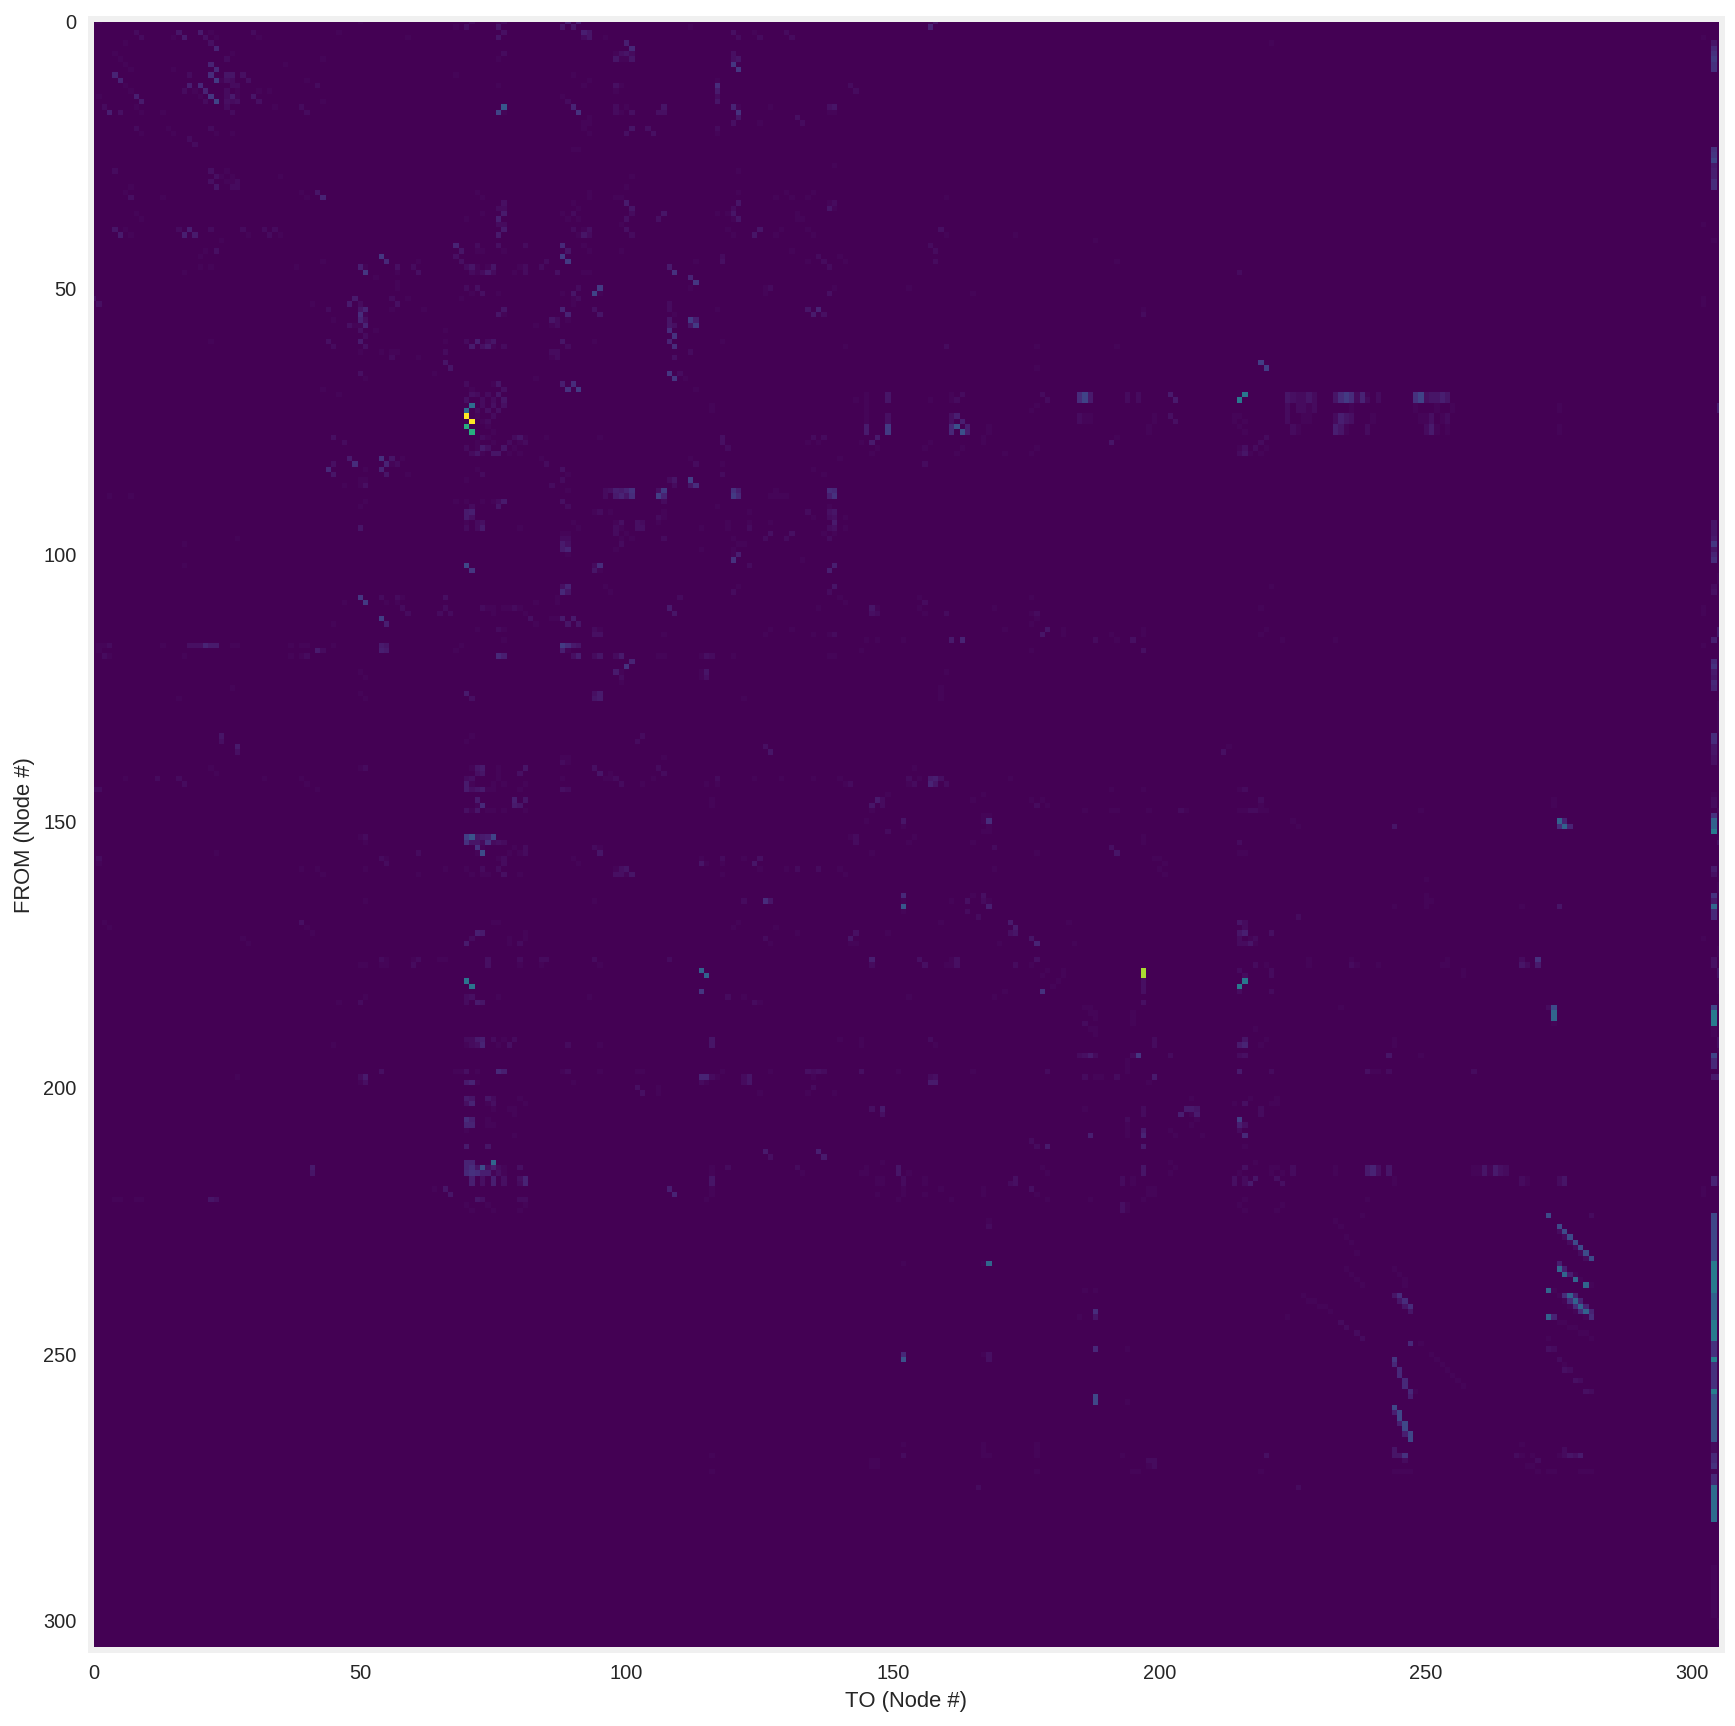

In [0]:
plt.figure(figsize = (15, 15))
plt.imshow(x_train, cmap='viridis', interpolation='nearest')
plt.grid(b=None)
plt.xlabel('TO (Node #)')
plt.ylabel('FROM (Node #)')
plt.show()

We can see sections of diagnoal and vertical lines in our heatmap representing clusters of neurons. Some bright spots that are symmetrical on either side of the matrix's diagonal represent neurons connected in very short loops. We can also see a few bright, highly-connected neurons. It's worth noting that since we have a directed graph, our matrix of the connection strengths is asymettric. Since neurons propagate signals in one direction, we can have elements in our matrix that represent strong connections going in one direction but not another.
 
 Of course, an improvement over the adjacency matrix for the graph would be looking at the graph itself. For example, we see a lot of bright spots in a column corresponding to column `304`. What does this look like in the graph?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


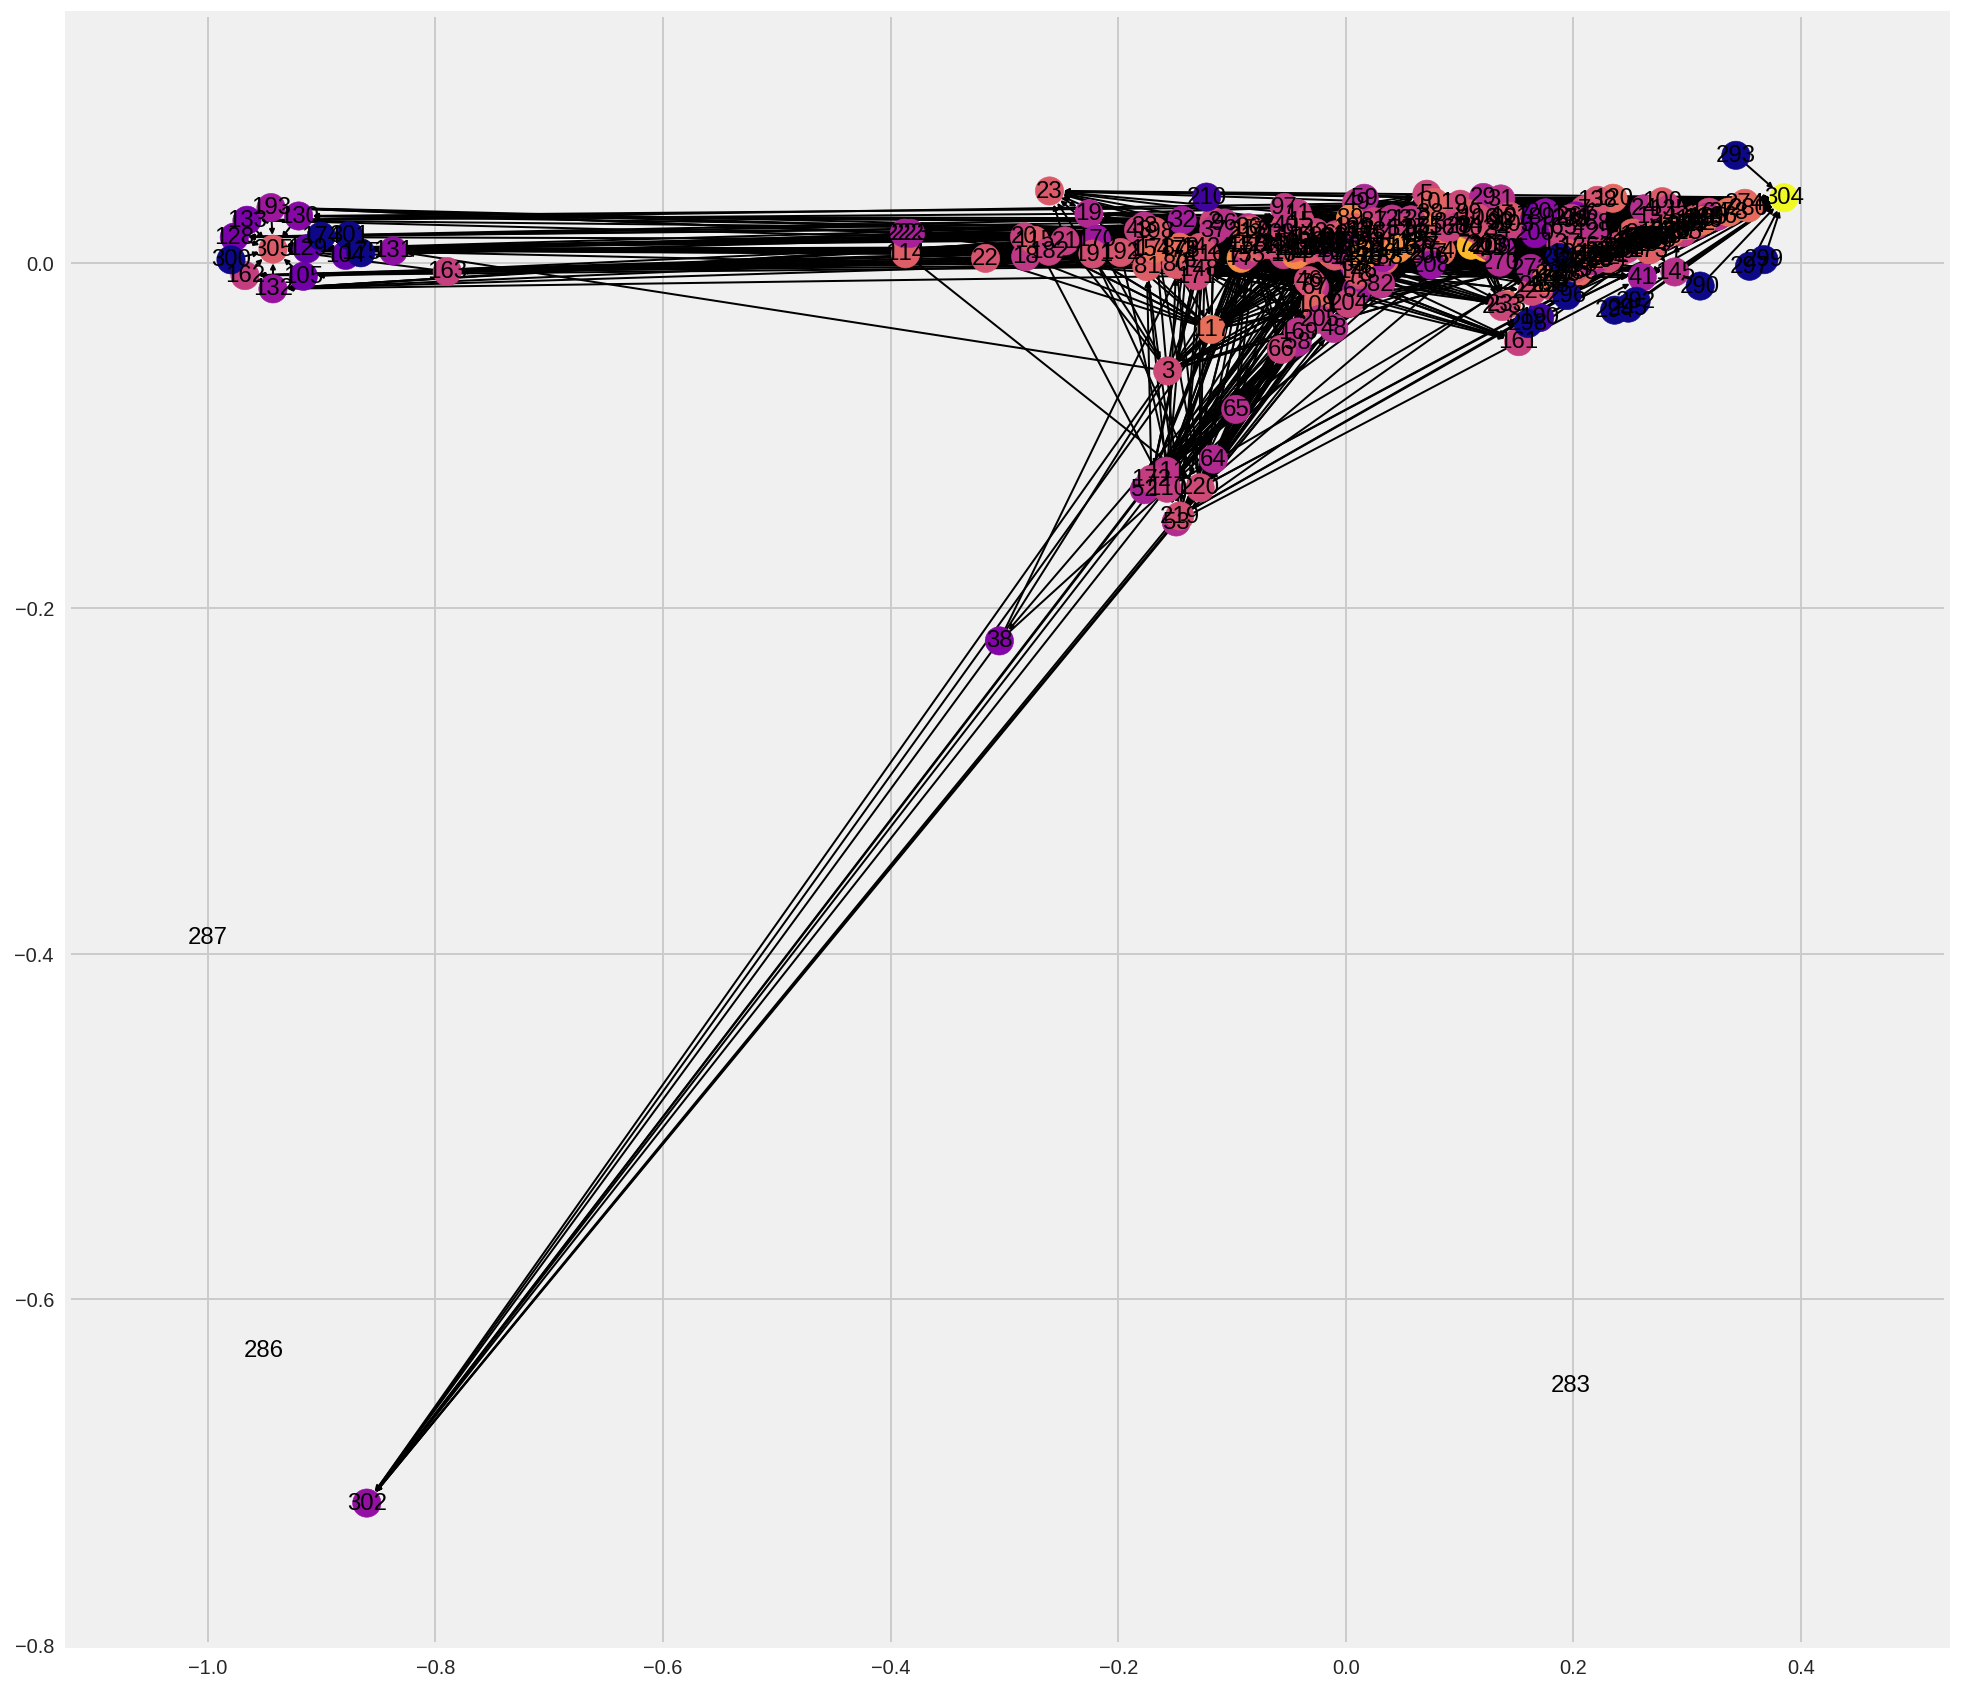

In [0]:
stimulations = x_train.sum(axis=0) + x_train.sum(axis=1)
stimulations = np.log(stimulations)
stimulation_max = stimulations.max()
stimulations = stimulations / stimulation_max

G = nx.DiGraph(x_train, directed=True)
plt.figure(figsize = (15, 15))

options = {
    'node_color': stimulations[G.nodes],
    'node_size': 200,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 5,
}
  
nx.draw_networkx(G, cmap=plt.cm.plasma, arrows=True, **options)

As we can see in the graph, all those bright spots represent a litanny of neurons sending signals to neuron # 302. We have a few neurons that are not connected to any others, but overall we can see a structure to the C. elegans nervous system.

Of course, when modelling a system like this, neurologists and developmental biologists would wonder more about hidden variables that dictate the structure of this. For example, the nervous system can be divided into many different lobes and sections. Some neurons communicate with each other using certain neurotransmitters but not others. Some neurons are sensory neurons, motor neurons, or inter neurons. Basically we have a bunch of hidden (or "latent") variables that dictate the underlying structure in this adjacency graph.

## Model

What can we learn about the neurons from their connectivity patterns? Using
a latent space model (Hoff et al., 2002), we will learn a latent
embedding for each neuron to capture the similarities between them.

Each neuron $n$ is a node in the network and is associated with a latent
position $z_n\in\mathbb{R}^K$.
We place a Gaussian prior on each of the latent positions.

The log-odds of an edge between node $i$ and
$j$ is proportional to the Euclidean distance between the latent
representations of the nodes $|z_i- z_j|$. Here, we
model the weights ($Y_{ij}$) of the edges with a Poisson likelihood.
The rate is the reciprocal of the distance in latent space. The
generative process is as follows:

1. 
For each node $n=1,\ldots,N$,
\begin{align}
z_n \sim \text{Normal}(0,I).
\end{align}
2. 
For each edge $(i,j)\in\{1,\ldots,N\}\times\{1,\ldots,N\}$,
\begin{align}
Y_{ij} \sim \text{Poisson}\Bigg(\frac{1}{|z_i - z_j|}\Bigg).
\end{align}

In TFP, we write the model for the $N \times N$ distance matrix as follows.

1. Create a vector, $[\parallel{z_1} \parallel^2, \parallel{z_2} \parallel^2, ..., \parallel{z_N} \parallel^2]$, and tile it (with `tf.tile`) to create $N$ identical rows.
2. Create a $N \times N$ matrix where entry $(i, j)$ has a value of $||z_i||^2 + ||z_j||^2 - 2 z_i^T z_j$.
3. Invert the pairwise distances and make rate along diagonals to be close to zero.

In [0]:
#@title Model Hyperparameters { display-mode: "form" }
#@markdown number of data points (default is 306, resulting from the shape of the dataset)
N = x_train.shape[0]  #@param {type:"raw"} 
#@markdown latent dimensionality (default is 3)
K = 3                 #@param {type:"integer"}


def trainable_normal(x, layer_fn=tf.layers.dense, loc_fn=lambda x: x, 
                     scale_fn=1., name=None):
    """Constructs a trainable `tfd.Normal` distribution.
    This function creates a Normal distribution parameterized by loc and scale.
    Using default args, this function is mathematically equivalent to:
    Args:
      x: `Tensor` with floating type. Must have statically defined rank and
        statically known right-most dimension.
      layer_fn: Python `callable` which takes input `x` and `int` scalar `d` and
        returns a transformation of `x` with shape
        `tf.concat([tf.shape(x)[:-1], [1]], axis=0)`.
        Default value: `tf.layers.dense`.
      loc_fn: Python `callable` which transforms the `loc` parameter. Takes a
        (batch of) length-`dims` vectors and returns a `Tensor` of same shape and
        `dtype`.
        Default value: `lambda x: x`.
      scale_fn: Python `callable` or `Tensor`. If a `callable` transforms the
        `scale` parameters; if `Tensor` is the `tfd.Normal` `scale` argument.
        Takes a (batch of) length-`dims` vectors and returns a `Tensor` of same
        size. (Taking a `callable` or `Tensor` is how `tf.Variable` intializers
        behave.)
        Default value: `1`.
      name: A `name_scope` name for operations created by this function.
        Default value: `None` (i.e., "normal").
    Returns:
      normal: An instance of `tfd.Normal`.
    """
    x = tf.convert_to_tensor(x, name='x')
    if callable(scale_fn):
        y = layer_fn(x, 2)
        loc = loc_fn(y[..., 0])
        scale = scale_fn(y[..., 1])
    else:
        y = tf.squeeze(layer_fn(x, 1), axis=-1)
        loc = loc_fn(y)
        scale = tf.cast(scale_fn, loc.dtype.base_dtype)
    return tfd.Normal(loc=loc, scale=scale)


def softplus_and_shift(x, shift=1e-5, name=None):
    """Converts (batch of) scalars to (batch of) positive valued scalars.
    Args:
      x: (Batch of) `float`-like `Tensor` representing scalars which will be
        transformed into positive elements.
      shift: `Tensor` added to `softplus` transformation of elements.
        Default value: `1e-5`.
      name: A `name_scope` name for operations created by this function.
        Default value: `None` (i.e., "positive_tril_with_shift").
    Returns:
      scale: (Batch of) scalars`with `x.dtype` and `x.shape`.
    """
    x = tf.convert_to_tensor(x, name='x')
    y = tf.nn.softplus(x)
    if shift is not None:
        y += shift
    return y


def tril_with_diag_softplus_and_shift(x, diag_shift=1e-5, name=None):
    """Converts (batch of) vectors to (batch of) lower-triangular scale matrices.
    Args:
      x: (Batch of) `float`-like `Tensor` representing vectors which will be
        transformed into lower-triangular scale matrices with positive diagonal
        elements. Rightmost shape `n` must be such that
        `n = dims * (dims + 1) / 2` for some positive, integer `dims`.
      diag_shift: `Tensor` added to `softplus` transformation of diagonal
        elements.
        Default value: `1e-5`.
      name: A `name_scope` name for operations created by this function.
        Default value: `None` (i.e., "tril_with_diag_softplus_and_shift").
    Returns:
      scale_tril: (Batch of) lower-triangular `Tensor` with `x.dtype` and
        rightmost shape `[dims, dims]` where `n = dims * (dims + 1) / 2` where
        `n = x.shape[-1]`.
    """
    with tf.name_scope(name, 'tril_with_diag_softplus_and_shift',
                       [x, diag_shift]):
        x = tf.convert_to_tensor(x, name='x')
        x = tfd.fill_triangular(x)
        diag = softplus_and_shift(tf.matrix_diag_part(x), diag_shift)
        x = tf.matrix_set_diag(x, diag)
        return x
    
    
def trainable_multivariate_normal_tril(x, dims, layer_fn=tf.layers.dense,
      loc_fn=lambda x: x, scale_fn=tril_with_diag_softplus_and_shift,
      name=None):
    """Constructs a trainable `tfd.MultivariateNormalTriL` distribution.
    Args:
      x: `Tensor` with floating type. Must have statically defined rank and
        statically known right-most dimension.
      dims: Scalar, `int`, `Tensor` indicated the MVN event size, i.e., the
        created MVN will be distribution over length-`dims` vectors.
      layer_fn: Python `callable` which takes input `x` and `int` scalar `d` and
        returns a transformation of `x` with shape
        `tf.concat([tf.shape(x)[:-1], [d]], axis=0)`.
        Default value: `tf.layers.dense`.
      loc_fn: Python `callable` which transforms the `loc` parameter. Takes a
        (batch of) length-`dims` vectors and returns a `Tensor` of same shape and
        `dtype`.
        Default value: `lambda x: x`.
      scale_fn: Python `callable` which transforms the `scale` parameters. Takes a
        (batch of) length-`dims * (dims + 1) / 2` vectors and returns a
        lower-triangular `Tensor` of same batch shape with rightmost dimensions
        having shape `[dims, dims]`.
        Default value: `tril_with_diag_softplus_and_shift`.
      name: A `name_scope` name for operations created by this function.
        Default value: `None` (i.e., "multivariate_normal_tril").
    Returns:
      mvntril: An instance of `tfd.MultivariateNormalTriL`.
    """
    x = tf.convert_to_tensor(x, name='x')
    x = layer_fn(x, dims + dims * (dims + 1) // 2)
    return tfd.MultivariateNormalTriL(
        loc=loc_fn(x[..., :dims]),
        scale_tril=scale_fn(x[..., dims:]))


class Progbar(object):
    def __init__(self, target, width=30, interval=0.01, verbose=1):
        """(Yet another) progress bar.
        Args:
          target: int.
            Total number of steps expected.
          width: int.
            Width of progress bar.
          interval: float.
            Minimum time (in seconds) for progress bar to be displayed
            during updates.
          verbose: int.
            Level of verbosity. 0 suppresses output; 1 is default.
        """
        self.target = target
        self.width = width
        self.interval = interval
        self.verbose = verbose

        self.stored_values = {}
        self.start = time.time()
        self.last_update = 0
        self.total_width = 0
        self.seen_so_far = 0

    def update(self, current, values=None, force=False):
        """Update progress bar, and print to standard output if `force`
        is True, or the last update was completed longer than `interval`
        amount of time ago, or `current` >= `target`.
        The written output is the progress bar and all unique values.
        Args:
          current: int.
            Index of current step.
          values: dict of str to float.
            Dict of name by value-for-last-step. The progress bar
            will display averages for these values.
          force: bool.
            Whether to force visual progress update.
        """
        if values is None:
            values = {}

        for k, v in six.iteritems(values):
            self.stored_values[k] = v

        self.seen_so_far = current

        now = time.time()
        if (not force and
                (now - self.last_update) < self.interval and
                current < self.target):
            return

        self.last_update = now
        if self.verbose == 0:
            return

        prev_total_width = self.total_width
        sys.stdout.write("\b" * prev_total_width)
        sys.stdout.write("\r")

        # Write progress bar to stdout.
        n_digits = len(str(self.target))
        bar = '%%%dd/%%%dd' % (n_digits, n_digits) % (current, self.target)
        bar += ' [{0}%]'.format(str(int(current / self.target * 100)).rjust(3))
        bar += ' '
        prog_width = int(self.width * float(current) / self.target)
        if prog_width > 0:
            try:
                bar += ('█' * prog_width)
            except UnicodeEncodeError:
                bar += ('*' * prog_width)

        bar += (' ' * (self.width - prog_width))
        sys.stdout.write(bar)

        # Write values to stdout.
        if current:
            time_per_unit = (now - self.start) / current
        else:
            time_per_unit = 0

        eta = time_per_unit * (self.target - current)
        info = ''
        if current < self.target:
            info += ' ETA: %ds' % eta
        else:
            info += ' Elapsed: %ds' % (now - self.start)

        for k, v in six.iteritems(self.stored_values):
            info += ' | {0:s}: {1:0.3f}'.format(k, v)

        self.total_width = len(bar) + len(info)
        if prev_total_width > self.total_width:
            info += ((prev_total_width - self.total_width) * " ")

        sys.stdout.write(info)
        sys.stdout.flush()

        if current >= self.target:
            sys.stdout.write("\n")


In [0]:
z = tfd.Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))
z_samples_ = evaluate(tfd.Normal(loc=tf.zeros([N]), scale=tf.ones([N])).sample(sample_shape=N))

qz = trainable_multivariate_normal_tril(z_samples_, dims=K)
print('Latent variable probability distribution: \n', qz, '\n')

Latent variable probability distribution: 
 tfp.distributions.MultivariateNormalTriL("MultivariateNormalTriL/", batch_shape=(306,), event_shape=(3,), dtype=float32) 



In [0]:
# Calculate N x N distance matrix.
# 1. Create a vector, [||z_1||^2, ||z_2||^2, ..., ||z_N||^2], and tile it to create N identical rows.
xp = tf.tile(tf.reduce_sum(tf.pow(qz.sample(), 2), 1, keepdims=True), [1, N])
print('Tile Vector: \n', xp)

# 2. Create a N x N matrix where entry (i, j) is ||z_i||^2 + ||z_j||^2 - 2 z_i^T z_j.
qz_sample = qz.sample()
xp = xp + tf.transpose(xp) - 2 * tf.matmul(qz_sample, qz_sample, transpose_b=True)
print('N x N matrix: \n', xp)

# 3. Invert the pairwise distances and make rate along diagonals to be close to zero.
xp = 1.0 / tf.sqrt(xp + tf.diag(tf.zeros(N) + 1e3))
print('Inverted pairwise distances: \n', xp)

xpn = tf.where(tf.is_nan(xp), tf.fill([N, N], (1.0 / 1e3)), xp)

x = tfd.Poisson(rate=xpn)
print('Poisson distribution with N x N outputs: \n', x)

Tile Vector: 
 Tensor("Tile:0", shape=(306, 306), dtype=float32)
N x N matrix: 
 Tensor("sub:0", shape=(306, 306), dtype=float32)
Inverted pairwise distances: 
 Tensor("truediv:0", shape=(306, 306), dtype=float32)
Poisson distribution with N x N outputs: 
 tfp.distributions.Poisson("Poisson/", batch_shape=(306, 306), event_shape=(), dtype=float32)


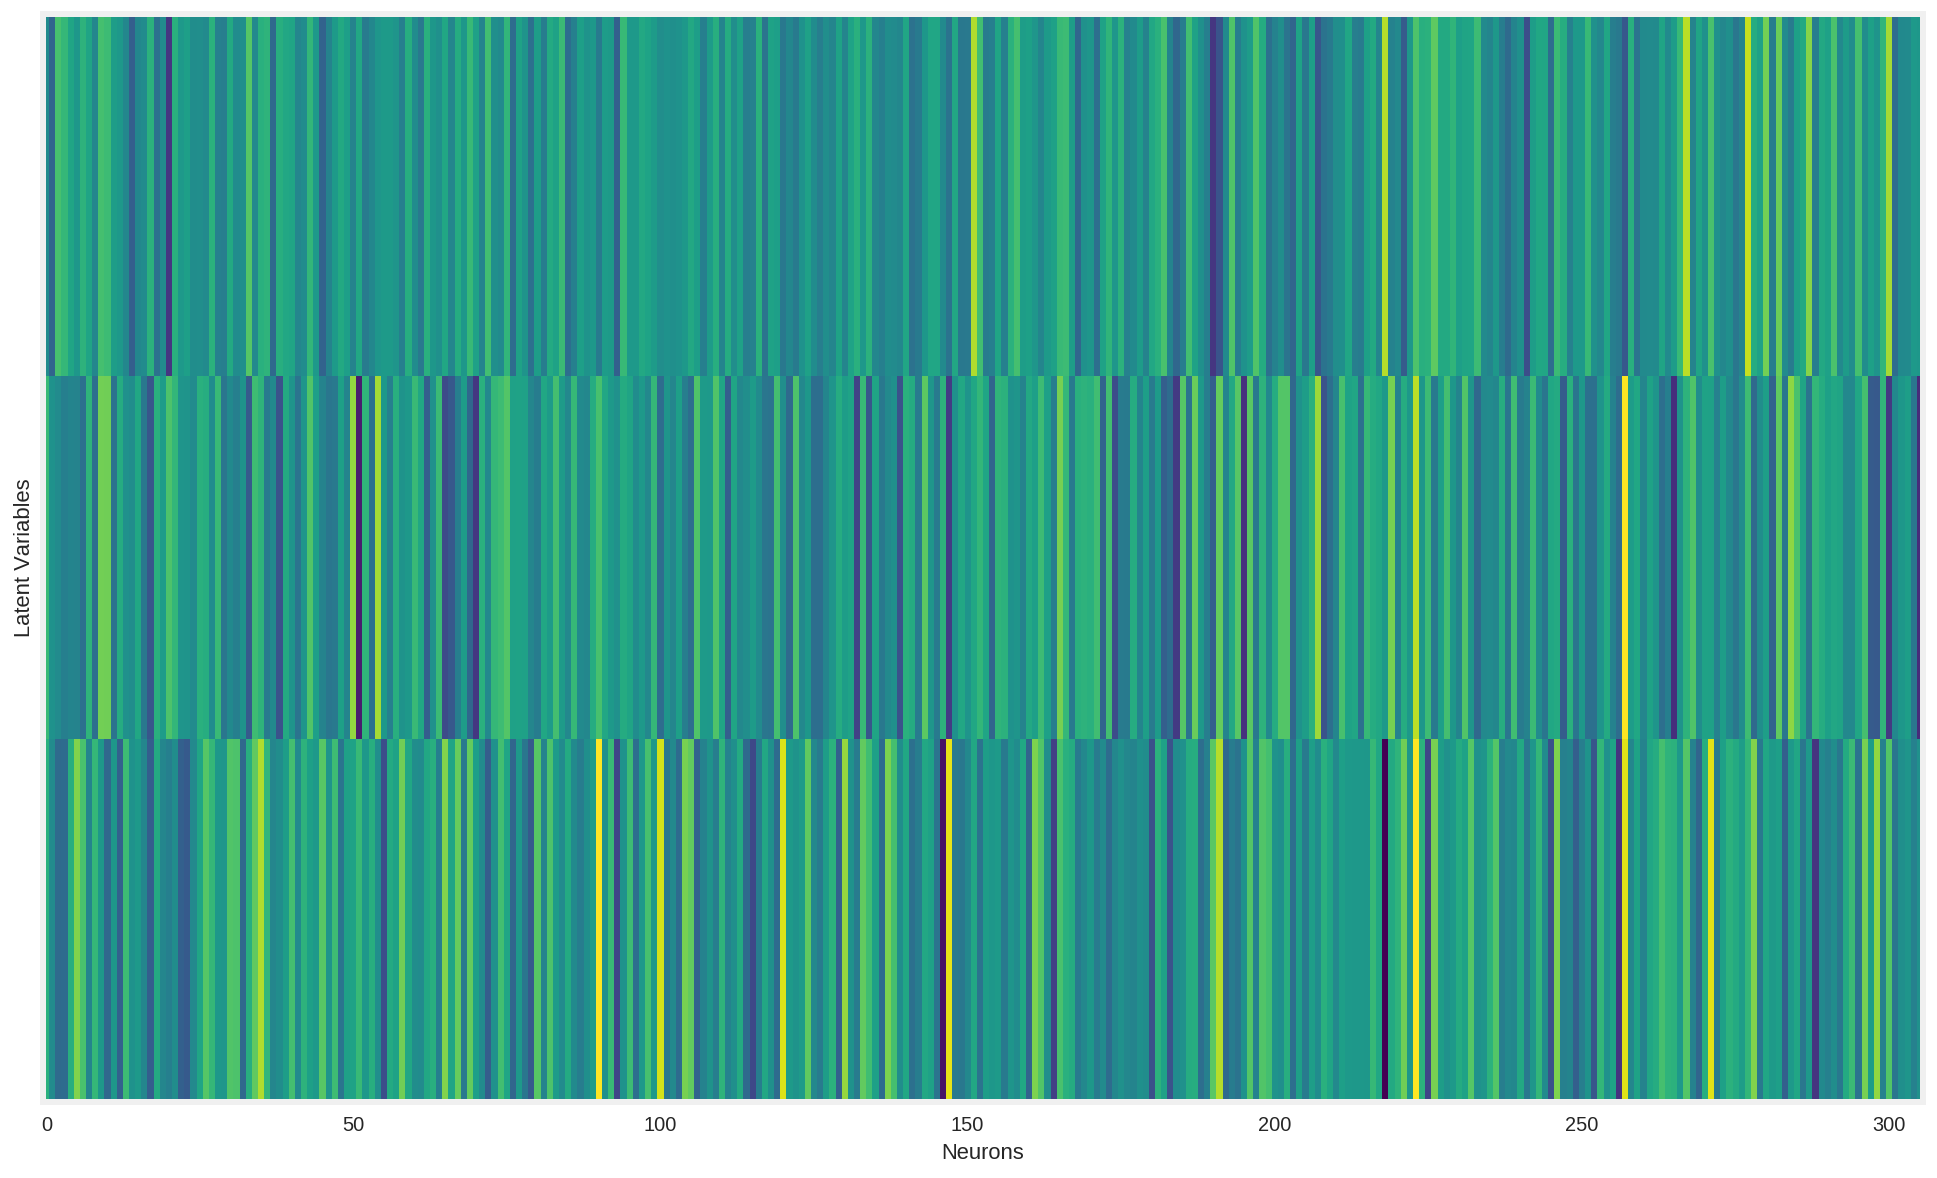

In [0]:
evaluate(tf.global_variables_initializer())

plt.figure(figsize = (15, 10))
plt.imshow(evaluate(qz_sample).transpose(), 
           cmap='viridis', 
           interpolation='nearest',
           aspect='auto')
plt.grid(b=None)
plt.xlabel('Neurons')
plt.ylabel('Latent Variables')
plt.yticks([])
plt.show()

## Inference

We can train our model using a combination of Maximum A Posteriori estimation via gradient descent, and KLqp inference. 

$-\text{ELBO} =
        -\mathbb{E}_{q(z; \lambda)} [ \log p(x, z) - \log q(z; \lambda) ]$
        
        
If the KL divergence between the variational model and the prior is tractable, then the loss function can be written as
$-\mathbb{E}_{q(z; \lambda)}[\log p(x \mid z)] + \text{KL}( q(z; \lambda) \| p(z) ),$
    where the KL term is computed analytically [@kingma2014auto]. We
    compute this automatically when $p(z)$ and $q(z; \lambda)$ are
    Normal.

In [0]:
# Maximum A Posteriori estimation
loss = -tf.reduce_sum(x.log_prob(x_train))

train_op = tf.train.AdamOptimizer(learning_rate=2.**-6).minimize(loss)

init_op = tf.global_variables_initializer()

# Run graph 2500 times.
num_steps = 240
loss_ = np.zeros(num_steps)   # Style: `_` to indicate evaluate result.
evaluate(init_op)
for it in range(loss_.size):
    _, qz_sample_, loss_[it] = evaluate([train_op, qz.sample(), loss])
    if it % 20 == 0 or it == loss_.size - 1:
        print("iterations:{}  loss:{:.6f}".format(it, loss_[it]))

iterations:0  loss:48977.601562
iterations:20  loss:71551.570312
iterations:40  loss:71551.570312
iterations:60  loss:71551.570312
iterations:80  loss:71551.570312
iterations:100  loss:71551.570312
iterations:120  loss:71551.570312
iterations:140  loss:71551.570312
iterations:160  loss:71551.570312
iterations:180  loss:71551.570312
iterations:200  loss:71551.570312
iterations:220  loss:71551.570312
iterations:239  loss:71551.570312


## Conclusions

So we have produced this training result, and we now have a poisson distribution with batches the same shape as our adjacency matrix, and parameters that come from a matrix of size $N$ neurons $\times$ $K$ latent dimensions. We started this tutorial with a hypothesis for how many latent dimensions were behind the larger trend in connectivity between the nodes in our directed graph. Given this model, the final losses are a pretty good approximation for how well our hypothesis stood to reality. 

So, that do these latent dimensions represent? From this simple example we do not know. We hypothesized an appropriate latent dimension number before getting to what those represent. In fact, you can even adjust the number of latent dimensions in the original *Model Hyperparameters* to try how different parameters perform.

C. elegans is also a very simple model organism to use in connectomics research. Compare their 306 neurons with the hundreds of thousands in fruit flies, or the billions in humans. Latent space models are also only a subset of the many tools used in connectomics. If you would like to learn more, you can read more about Google's Connectomics research [here](https://ai.google/research/teams/perception/connectomics/).

## References
1. Goldenberg, A., Zheng, A. X., Fienberg, S. E., & Airoldi, E. M. (2010). [A survey of statistical network models.](https://www.nowpublishers.com/article/Details/MAL-005) Foundations and Trends in Machine Learning.
2. Hoff, P. D., Raftery, A. E., & Handcock, M. S. (2002). [Latent space approaches to social network analysis.](https://amstat.tandfonline.com/doi/abs/10.1198/016214502388618906#.W2X9PN-YW8g) Journal of the American Statistical Association, 97(460), 1090–1098.
3. Newman, M. (2010). [Networks: An introduction.](https://books.google.com/books?hl=en&lr=&id=YdZjDwAAQBAJ&oi=fnd&pg=PP1&dq=networks+an+introduction+newman&ots=V_IZ1Qkcrv&sig=e32XDZs8gzBAHzsBGEYVmWQhsis#v=onepage&q=networks%20an%20introduction%20newman&f=false) Oxford University Press.
4. Watts, D. J., & Strogatz, S. H. (1998). [Collective dynamics of ‘small-world’networks.](https://www.nature.com/articles/30918) Nature, 393(6684), 440–442.
5. White, J. G., Southgate, E., Thomson, J. N., & Brenner, S. (1986). [The structure of the nervous system of the nematode caenorhabditis elegans.](https://pdfs.semanticscholar.org/0bb2/1a76b5604211927cbc3c18f64437adbd834a.pdf) Philos Trans R Soc Lond B Biol Sci, 314(1165), 1–340.